Tract DataFrame columns: Index(['NAME', 'B19013_001E', 'state', 'county', 'tract'], dtype='object')
County DataFrame columns: Index(['NAME', 'B19013_001E', 'state', 'county'], dtype='object')
Tract DataFrame head:                                             NAME  B19013_001E state county  \
0  Census Tract 4001, Alameda County, California     224821.0    06    001   
1  Census Tract 4002, Alameda County, California     201154.0    06    001   
2  Census Tract 4003, Alameda County, California     127333.0    06    001   
3  Census Tract 4004, Alameda County, California     146265.0    06    001   
4  Census Tract 4005, Alameda County, California     101597.0    06    001   

    tract STATEFP COUNTYFP        GEOID  
0  400100      06      001  06001400100  
1  400200      06      001  06001400200  
2  400300      06      001  06001400300  
3  400400      06      001  06001400400  
4  400500      06      001  06001400500  
County DataFrame head:                            NAME  B19013_00

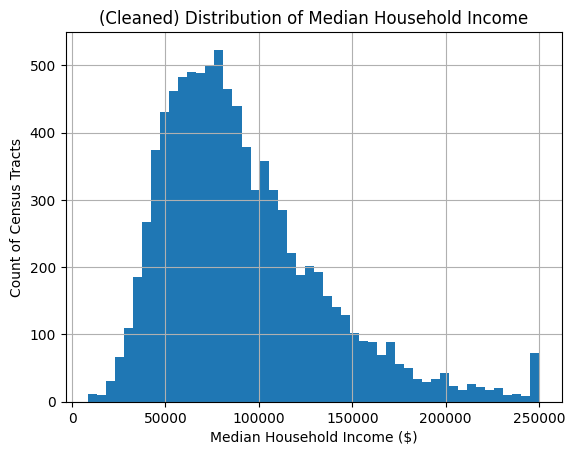

GeoJSON file saved to ../data/geojson/california_census_tracts_median_income_downsampled.geojson


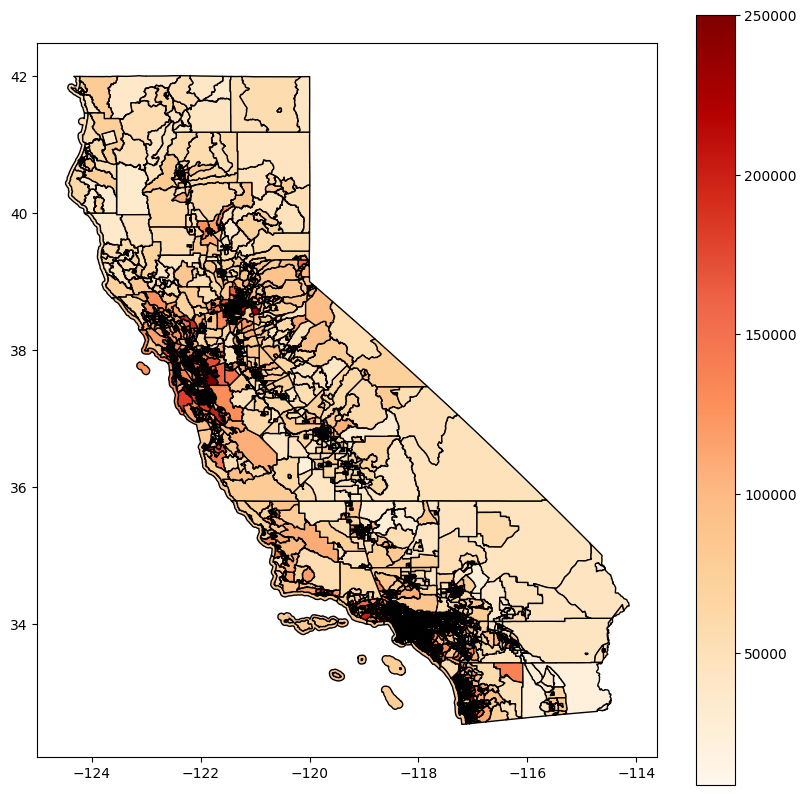

In [9]:
import requests
import zipfile
import io
import geopandas as gpd
import pandas as pd
from census import Census
from us import states
from functools import lru_cache
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"
census_api_key = os.getenv('CENSUS_API_KEY')

def fetch_shapefile(url):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall("tract_shapefiles")
    return gpd.read_file("tract_shapefiles/tl_2023_06_tract.shp")

tracts = fetch_shapefile(shapefile_url)

c = Census(census_api_key)

@lru_cache(maxsize=None)
def get_census_data(level):
    if level == 'tract':
        return c.acs5.state_county_tract(('NAME', 'B19013_001E'), states.CA.fips, Census.ALL, Census.ALL, year=2021)
    elif level == 'county':
        return c.acs5.state_county(('NAME', 'B19013_001E'), states.CA.fips, Census.ALL, year=2021)

# Retrieve median household income at the tract level in California (2021 data)
response_tracts = get_census_data('tract')

# Retrieve median household income at the county level in California (2021 data)
response_counties = get_census_data('county')

tract_df = pd.DataFrame(response_tracts)
county_df = pd.DataFrame(response_counties)

# Debug statements
print("Tract DataFrame columns:", tract_df.columns)
print("County DataFrame columns:", county_df.columns)

# Convert the county FIPS codes to strings and zero-pad them to 3 digits for proper matching
tract_df['STATEFP'] = tract_df['state'].apply(lambda x: str(x).zfill(2))
tract_df['COUNTYFP'] = tract_df['county'].apply(lambda x: str(x).zfill(3))
tract_df['tract'] = tract_df['tract'].apply(lambda x: str(x).zfill(6))
tract_df['GEOID'] = tract_df['STATEFP'] + tract_df['COUNTYFP'] + tract_df['tract']
tract_df['B19013_001E'] = pd.to_numeric(tract_df['B19013_001E'], errors='coerce')

county_df['STATEFP'] = county_df['state'].apply(lambda x: str(x).zfill(2))
county_df['COUNTYFP'] = county_df['county'].apply(lambda x: str(x).zfill(3))
county_df['GEOID'] = county_df['STATEFP'] + county_df['COUNTYFP']
county_df['B19013_001E'] = pd.to_numeric(county_df['B19013_001E'], errors='coerce')

print("Tract DataFrame head:", tract_df.head())
print("County DataFrame head:", county_df.head())

# Merge with geographic shapefiles using the GEOID field
merged_gdf = tracts.merge(tract_df, on='GEOID')

print("Merged GeoDataFrame columns:", merged_gdf.columns)

# Replace negative values with NaN or filter them out entirely
merged_gdf.loc[merged_gdf['B19013_001E'] < 0, 'B19013_001E'] = float('nan')

# Ensure COUNTYFP is in merged_gdf
if 'COUNTYFP' not in merged_gdf.columns:
    merged_gdf['COUNTYFP'] = merged_gdf['GEOID'].str[2:5]

print("GeoDataFrame with COUNTYFP:", merged_gdf.head())

# Apply county-level median income to missing census tract data
merged_gdf = merged_gdf.merge(county_df[['COUNTYFP', 'B19013_001E']], on='COUNTYFP', suffixes=('', '_county'))
merged_gdf['B19013_001E'] = merged_gdf['B19013_001E'].combine_first(merged_gdf['B19013_001E_county'])
merged_gdf = merged_gdf.drop(columns=['B19013_001E_county'])

# Alternatively, drop rows with negative or missing income values
merged_gdf_clean = merged_gdf[merged_gdf['B19013_001E'] >= 0].dropna(subset=['B19013_001E'])

print(merged_gdf_clean['B19013_001E'].describe())

# Plot the histogram of median household income
merged_gdf_clean['B19013_001E'].hist(bins=50)
plt.xlabel('Median Household Income ($)')
plt.ylabel('Count of Census Tracts')
plt.title('(Cleaned) Distribution of Median Household Income')
plt.show()

# Plot the merged data (geometry with median income)
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf_clean.plot(column='B19013_001E', ax=ax, legend=True, cmap='OrRd', edgecolor='black')

merged_gdf_clean = merged_gdf_clean.to_crs(epsg=4326)

output_geojson_path = "../data/geojson/california_census_tracts_median_income_downsampled.geojson"
merged_gdf_clean.to_file(output_geojson_path, driver='GeoJSON')

print(f"GeoJSON file saved to {output_geojson_path}")
